In [5]:
import sys
import os
import numpy as np
import pyccl as ccl
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import quad,simps, dblquad
from scipy.optimize import curve_fit

In [6]:
os.environ['CLMM_MODELING_BACKEND'] = 'nc'
import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [7]:
clmm.__version__

'1.0.4'

In [8]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

In [9]:
cluster_m_true = 1e14
cluster_z_true = 0.5
concentration_true = 4
a = 0.9
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
mock_cosmo = cosmo
moo.set_cosmo(mock_cosmo)

### Compute Miscentering

In [10]:
def excess_surface_density(single_catalog = None, radial_bin = None, sigma_c = None):
    r"""
    Attributes:
    -----------
    
    single_catalog : GalaxyCluster object
    
    radial_bin : liste
        radial bins to evaluate the binned excess surface density
    
    sigma_c : string 
        column name in the single_catalog for the critical surface mass density
        
    Returns:
    --------
    
    ds, r, sum_weights : array, array, array
        the binned excess surface density, the binned radius, the sum of weights w_ls in each radial bin

    """
    
    ds = np.zeros(len(radial_bin))
    
    r = np.zeros(len(radial_bin))
    
    sum_weights = np.zeros(len(radial_bin))
    
    for i, r_bin in enumerate(radial_bin):

        mask = (single_catalog.galcat['R'] > r_bin[0])*(single_catalog.galcat['R'] < r_bin[1])
        
        w_ls = 1./single_catalog.galcat[sigma_c][mask]**2
        
        ds[i] = np.average(single_catalog.galcat['et'][mask]*single_catalog.galcat[sigma_c][mask], weights = w_ls)
        
        r[i] = np.average(single_catalog.galcat['R'][mask])
        
        sum_weights[i] = np.sum( w_ls )
        
    return ds, r, sum_weights

In [11]:
c, m, z = concentration_true, cluster_m_true, cluster_z_true
ngals = 30000

In [13]:
noisy_data_z_single = mock.generate_galaxy_catalog(m, z, c, cosmo, 
                                                zsrc = 'chang13', 
                                                #Delta_SO=200, 
                                               massdef='critical',
                                               halo_profile_model='nfw', zsrc_min=z + 0.1,
                           zsrc_max=3., field_size=15., shapenoise=0.01, photoz_sigma_unscaled=0, ngals=ngals)

cl_single = clmm.GalaxyCluster('mock_cluster', 0., 0., z, noisy_data_z_single)

cl_single.compute_tangential_and_cross_components(geometry="flat",
                                                  shape_component1='e1', shape_component2='e2', 
                                                  tan_component='et', cross_component='ex',
                                                  add=True, is_deltasigma = False, cosmo = cosmo)

cl_single.galcat['R'] = mock_cosmo.eval_da_z1z2(0,z)*cl_single.galcat['theta']

ang, phi = clmm.dataops._compute_lensing_angles_flatsky(cl_single.ra, cl_single.dec, cl_single.galcat['ra'], cl_single.galcat['dec'])

cl_single.galcat['phi'] = np.array(phi)

cl_single.galcat['sigma_c'] = mock_cosmo.eval_sigma_crit(z, cl_single.galcat['z'])

In [14]:
R = np.logspace(np.log10(1), np.log10(7), 20)
radial_bin = [[R[i], R[i+1]] for i in range(len(R)-1)]

In [15]:
ds_single,r_single,sum_weight_single = excess_surface_density(single_catalog = cl_single, radial_bin = radial_bin, sigma_c = 'sigma_c')

In [16]:
def jackknife(single_catalog = None, N_jk = None):
    
    r"""
    Attributes:
    -----------
    single_catalog : GalaxyCluster object
        GalaxyCluster object of a single cluster 
    N_jk : int
        number of jackknife regions
        
    Returns:
    --------
    cov : array
        Jackknife delete-1 covariance matrix
    
    """
    
    phi = np.linspace(-np.pi, np.pi, N_jk + 1)
    
    phi_bin = binning(phi)
    
    gt = []
    
    mask_list_in = [(phi_[0] < single_catalog.galcat['phi'])*(single_catalog.galcat['phi'] < phi_[1]) for phi_ in phi_bin]
    
    for s, phi_ in enumerate(phi_bin):
        
        mask_in = mask_list_in[s]
        
        mask_out = np.invert(mask_in)
        
        plt.scatter(single_catalog.galcat['ra'][mask_in], single_catalog.galcat['dec'][mask_in], s = 1)
        
        data_cut = single_catalog.galcat[mask_out]
        
        cl_cut_jack = clmm.GalaxyCluster('Stack', single_catalog.ra, single_catalog.dec, single_catalog.z, single_catalog.galcat[mask_out])
        
        ds, r, sum_weights = excess_surface_density(single_catalog = cl_cut_jack, radial_bin = radial_bin, sigma_c = 'sigma_c')
        
        gt.append(ds)

    gt = np.array(gt)
    
    cov = np.cov(gt.T)*(N_jk-1)**2/N_jk
    
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.axis('equal')
        
    return cov

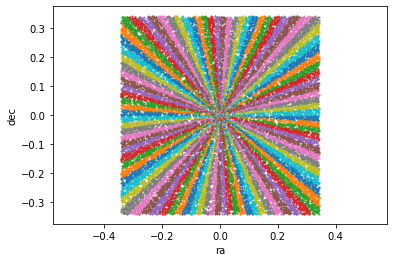

In [17]:
cov_single = jackknife(single_catalog = cl_single, N_jk = 100)

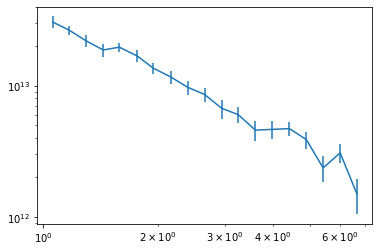

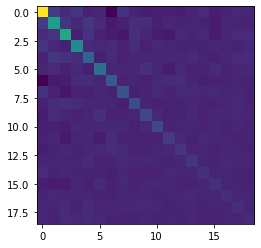

In [18]:
plt.errorbar(r_single, ds_single, np.sqrt(cov_single.diagonal()))
plt.loglog()
plt.figure()
plt.imshow(cov_single)

In [19]:
def model(theta):
    c, logm = theta
    moo.set_mass(10**logm) 
    moo.set_concentration(c)
    return moo.eval_excess_surface_density(r_single, cluster_z_true)

In [20]:
import iminuit
from iminuit import Minuit
def negative_lnL(c, logm):
    #if a < 0: return np.inf
    if c < 0: return np.inf
    theta = c, logm
    y_th = model(theta)
    inv_cov = np.linalg.inv(cov_single)
    d = y_th - ds_single
    res = 0.5*np.sum(d*inv_cov.dot(d))
    return res
def lnL_emcee(theta):
    c, logm = theta
    return -negative_lnL(c, logm)

minuit = Minuit(negative_lnL, logm = 14, c = 4, limit_logm = (12,18),limit_c = (0,18),
                   errordef = 0.5)
        
minuit.migrad(),minuit.hesse(),minuit.minos()

(┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.043                      │         Nfcn = 44 (44 total)         │
│ EDM = 3.65e-07 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────

In [21]:
cov_minuit = np.array(minuit.matrix())

In [22]:
import emcee
initial = [concentration_true, np.log10(cluster_m_true)]
npath = 500
nwalkers = 100
pos = initial + 0.01 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_single = emcee.EnsembleSampler(nwalkers, ndim, lnL_emcee)
print('Single cluster : running...')
sampler_single.run_mcmc(pos, npath, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]

Single cluster : running...


100%|██████████| 500/500 [00:15<00:00, 31.55it/s]


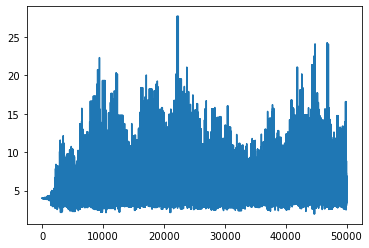

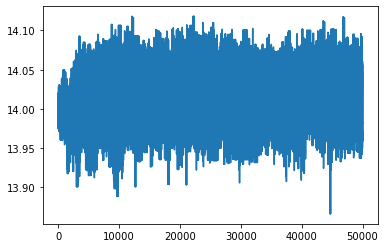

<Figure size 432x288 with 0 Axes>

In [23]:
flat_sample_single_pre_cut = sampler_single.get_chain(discard = 0, thin = 1, flat = True)
for i in range(len(initial)):
    plt.plot(flat_sample_single_pre_cut[:,i])
    plt.figure()

In [24]:
%load_ext autoreload

%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import DATAOPS_Fisher_matrix as fisher

In [25]:
mean = np.array([minuit.values['c'],minuit.values['logm'],])
#mean = [ concentration_true, np.log10(cluster_m_true),]
Fisher_matrix = fisher.Fisher_Matrix(mean, model, cov_single)
S_matrix = fisher.S_Fisher_Matrix(mean, model, cov_single)
Q_matrix = fisher.Q_Fisher_Matrix(mean, model, cov_single)

In [26]:
import iminuit
from iminuit import Minuit
def lnL_parameters(theta, MLE, Fisher_matrix, S_matrix, Q_matrix):
    
    dtheta = theta - MLE
    
    lnL_Gaussian = -0.5*np.sum(dtheta*Fisher_matrix.dot(dtheta))
    
    s = 0
    q = 0
    
    for i in range(len(theta)):
        for j in range(len(theta)): 
            for k in range(len(theta)):
                s += S_matrix[i,j,k]*dtheta[i]*dtheta[j]*dtheta[k]
                for l in range(len(theta)):
                        q += Q_matrix[i,j,k,l]*dtheta[i]*dtheta[j]*dtheta[k]*dtheta[l]
                        
    #for i in range(len(theta)):
      #  for j in range(len(theta)): 
       #     for k in range(len(theta)):
       #***         s += S_matrix[i,j,k]*dtheta[i]*dtheta[j]*dtheta[k]
                        
    
    lnL_S_Gaussian = -(1./2.)*s
    lnL_Q_Gaussian = -(1./8.)*q
    
    return lnL_Gaussian +  lnL_S_Gaussian + lnL_Q_Gaussian 

In [27]:
lnL_parameters(mean + 0.001*mean, mean, Fisher_matrix, S_matrix, Q_matrix)

-0.4732431605141302

In [ ]:
def lnL_emcee_param(theta):
    c, logm = theta
    if c < 0.00: return -np.inf
    return lnL_parameters(theta, mean, Fisher_matrix, S_matrix, Q_matrix)

In [ ]:
import emcee
initial = [concentration_true, np.log10(cluster_m_true)]
npath = 500
nwalkers = 500
pos = initial + 0.001 * np.random.randn(nwalkers, len(initial))
nwalkers, ndim = pos.shape
sampler_param = emcee.EnsembleSampler(nwalkers, ndim, lnL_emcee_param)
print('Single cluster : running...')
sampler_param.run_mcmc(pos, npath, progress=True);

In [ ]:
discard, thin = 200, 10
flat_sample_single = sampler_single.get_chain(discard = discard, thin = thin, flat = True)
flat_sample_param = sampler_param.get_chain(discard = discard, thin = thin, flat = True)
import numpy as np
from chainconsumer import ChainConsumer
labels = [r'$c_{\rm 200c}$', r'$\log_{10} M_{\rm 200c}$']

cs = ChainConsumer()
cs.add_chain(flat_sample_single, parameters=labels, name = 'MCMC')
data = np.random.multivariate_normal(mean, cov_minuit, size=100000)
#cs.add_chain(data,parameters=labels, name = 'Minuit Covariance Matrix')
data = np.random.multivariate_normal(mean, np.linalg.inv(Fisher_matrix), size=100000)
cs.add_chain(data,parameters=labels, name = 'Fisher Matrix')
cs.add_chain(flat_sample_param,parameters=labels, name = 'S-Fisher Matrix')
fig = cs.plotter.plot(figsize="column", truth=mean)
#fig = cs.plotter.plot(figsize="column", truth=mean)
fig.set_size_inches(10, 10)
